# Amplitude Cross Correlation Performance

The purpose of this notebook is to investigate the sensitivity of amplude cross correlation for speckle tracking to various parameters. For simplicity, all experiments assume small offsets (< 1 pixel). As a result, circular convolution is used. In actuality, a zero padded buffer may be needed to expand the search radius, but the peformance with respect to the parameters examined here should be similar. For further simplicity, all matches are performed with a square windows (though the code can support rectangular windows.)

## Supporting Code

The results in this notebook make use of a supporting set of python functions that can be found at: https://github.com/fastice/nisarfunc. To install, go to a directory in your Python path (if you haven't set a Python path you will need to; google "setting python path".) The necesary functions are then imported as:

In [1]:
import nisarfunc as nf

Other packages that are used are imported as (you may need to install if they don't load):

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
%load_ext autoreload
%autoreload 2

Note these experiments use an fft to oversample the correlation peak to obtain subpixel results. The code is written so that a different peak interpolator can be used. Specifically, the cross correlation is defined as `nccPatches(...subPix=osSubPix, subPixArgs=(10, 4), subPixKwArgs={})` so that the oversampling is accomplished as `subPix(*subPixArgs, **subPixKwArgs)`.

Since the simulations are can be time consuming if a lot of realizations are used, the code can be multi-threaded to run `nJobs` as:

    speckleJobs = nf.speckleJobs(myFunction) # Setup an object to multi-thread myFunction 
    speckleJobs.runNInstances(nJobs, arg1, arg2,..,keyw1=....) 
    results = speckleJobs.results # list with nJob elements, each containing a thread output 
    speckleJobs.reset() # Reset to run a fresh set (otherwise results will be accumulated)

### Number of Instances

More samples will improve the quality of the estimates, but take longer to run. The variable `nInstances` is used by all simulations. It can be set to a low number for debugging and notebook demonstration and to a larger number to generate higher fidelity results.

In [3]:
nInstances = 1000

## Sensitivity to Window Size

The search window size for correlation matching is an important parameter in matching. In generally, larger windows should yield cleaner matches, but with some caveats. As windows get larger, the potential for phase gradients to reduce correlation increases. Furthermore, larger windows yield lower resolution. In addition, there is always some quantization error depending on how finely the peak can be resolve, so at some point that can set a noise floor so that larger windows produce little added benefit. In such cases, its likely better to average results from several smaller windows, which reduce quantization noise. 

The following function will simulate white noise patches with a specified level of correlation $\rho$ and subpixel row and column offsets ($\delta_r$ and $\delta_c$). The cross correlation algorithm will then return estimates of these offsets ($\hat{\delta_r}$ and $\hat{\delta_c}$). The routine will then return the errors ($e_r = \hat{\delta_r} - \delta_r$ and $e_c = \hat{\delta_c} - \delta_c$).

In [4]:
def ampWindowSize(ws, rho, osPeak, osBox, overSample=False, subPix=nf.osSubPix):
    # randomize both the osFactor and offset to vary offsets
    osFactor = random.randint(6,8)  # Oversample factor used to generate shifts, so shifts in increments of 1/osFactor
    deltaR, deltaC = random.randint(1, osFactor-1), random.randint(1, osFactor-1)  # Randomly vary offsets to avoid an single offset bias
    patchS, patchR = nf.correlatedShiftedPatches(ws, ws, deltaR, deltaC, rho, overSample=osFactor, sigma=1.0)  # sim data
    deltaRHat, deltaCHat, cmax, _, _ = nf.nccPatches(patchS, patchR, subPixArgs=(osPeak, osBox),
                                                     overSampleCorr=overSample, ampMatch=True, subPix=subPix)
    return deltaRHat - deltaR/osFactor, deltaCHat - deltaC/osFactor

def matchStats(results):
    ''' Compute stats from results'''
    if np.sum(np.isfinite(results)) != 0:  # Check that not all failed
        sigma= np.nanstd(results)
        percentSuccess = np.sum(np.isfinite(results)) / (results.shape[0] * results.shape[1]) * 100.
        return sigma, percentSuccess
    return np.nan, 0

The results in many of the following examples can be plotted as:

In [5]:
def plotErrorAndSuccessRate(resultsSigma, resultsPercent, rhos, windows, title='', formatRho=False, \
                            xlabel='Window Size (pixels)', ylabels=['Error (pixels)', '% success'], maxError=None):
    fig, myAxes = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle(title, fontsize=16)
    for rho in rhos:
        if formatRho:  # Kluge to deal with \ 
            myAxes[0].plot(windows, resultsSigma[rho],'*-', label=f'$\{rho}$')
            myAxes[1].plot(windows, resultsPercent[rho],'*-', label=f'$\{rho}$')
        else:
            myAxes[0].plot(windows, resultsSigma[rho],'*-', label=rho)
            myAxes[1].plot(windows, resultsPercent[rho],'*-', label=rho)
    for myAxis, xlab, ylab in zip(myAxes, [xlabel] * 2, ylabels):
        myAxis.legend()
        myAxis.set_xlabel(xlab, fontSize=14)
        myAxis.set_ylabel(ylab, fontSize=14)
    if maxError is not None:
        if max([max(x) for x in resultsSigma.values()]) > maxError:
            myAxes[0].set_ylim([0,maxError])

The following code simulates errors for several window sizes and values of complex correlation, $\rho$.

In [6]:
def windowSimAmp(windows, rhos, overSample):
    speckleJobs = nf.speckleJobs(ampWindowSize)
    resultsSigma = {rho : [] for rho in rhos}
    resultsPercent = {rho : [] for rho in rhos}
    osPeak, osBox = 40, 4
    for rho in rhos:
        for window in windows:
            print(f'\rrho={rhos[rho]} window {window} ', end='')
            speckleJobs.runNInstances(nInstances, window, rhos[rho], osPeak, osBox, overSample=overSample)
            sigma, percentSuccess = matchStats(np.array(speckleJobs.results))
            resultsSigma[rho].append(sigma)
            resultsPercent[rho].append(percentSuccess)
            speckleJobs.reset()
    # Plot results
    plotErrorAndSuccessRate(resultsSigma, resultsPercent, rhos, windows, formatRho=True,\
                            title=f'Peformance vs Window Size for osPeak={osPeak}, $\pm$osBox={osBox}, '
                            f'overSample={overSample}, nSamples={nInstances}')

### Window Size Parameters

The following parameters are used for the window size simulations:

In [7]:
windows = [32, 48, 64, 96, 128, 196]
rhos = {'rho=0.2': 0.2, 'rho=0.3' : 0.3, 'rho=0.4' : 0.4, 'rho=0.5' : 0.5, 'rho=0.8': 0.8}

### Window Size Simulations with no Oversampling

These simulations evaluate peformance for the case with no oversampling.

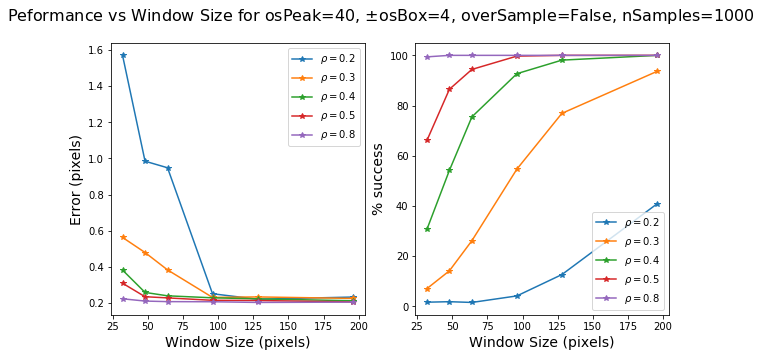

In [8]:
overSample = False
windowSimAmp(windows, rhos, overSample)

**Figure 1. Matching performance as a function of window size with no oversampling prior to correlation in terms of (left) error and (right) probability of success. Each curve corresponds to a different value of the the complex correlation, $\rho$ (see legend.)**

## Oversampling

Oversampling should important for amplitude images due to the spectral aliasing when the image is detected. As a result, most amplitude matchers oversample the data prior to matching. This example demonstrates the improvement from oversampling.

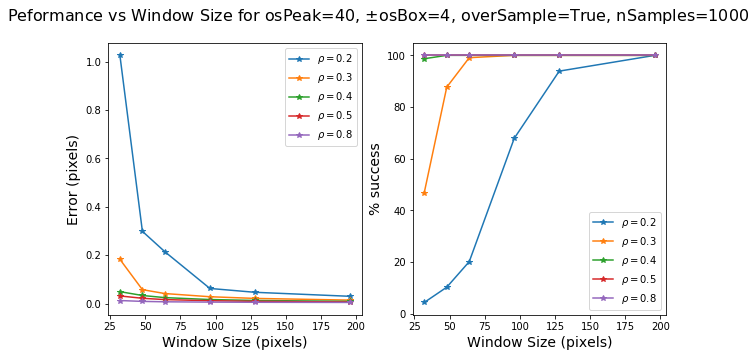

In [9]:
overSample = True
windowSimAmp(windows, rhos, overSample)

**Figure 2. Matching performance as a function of window size with 2xoversampling prior to correlation in terms of (left) error and (right) probability of success. Each curve corresponds to a different value of the the complex correlation, $\rho$ (see legend.)**

## Peak Oversample Factor

There are multiple ways to oversample the peak the range from oversamping to fitting some functional form (polynomial or Gaussian). A simple and straight forward approach is to extract the region with $\pm$`osBox` around the correlation peak, oversample that by a factor `osPeak`, and then find the subpixel maximimum from this result. Since the peak cannot be oversampled with infinite precision, there should be an upper limits on `osBox` and `osPeak` after which the point of diminishing returns is reached. This code evaluates the accuracy (or at least precision) of the oversampling operations over a range of `osBox` and `osPeak` values.

In [10]:
def simOverSamplePeak(window, rho, overSample, subPix=nf.osSubPix, osPeaks=[10, 20, 40, 80],
                      osBoxes=[2, 4, 8, 16], maxError=None):
    speckleJobs = nf.speckleJobs(ampWindowSize)
    resultsSigma = {f'osPeak={osPeak}' : [] for osPeak in osPeaks}
    resultsPercent = {f'osPeak={osPeak}' : [] for osPeak in osPeaks}
    #
    for osPeak in osPeaks:
        for osBox in osBoxes:
            print(f'\rosBox={osBox} osPeak {osPeak} ', end='')
            speckleJobs.runNInstances(nInstances, window, rho, osPeak, osBox, overSample=overSample, subPix=subPix)
            sigma, percentSuccess = matchStats(np.array(speckleJobs.results))
            resultsSigma[f'osPeak={osPeak}'].append(sigma)
            resultsPercent[f'osPeak={osPeak}'].append(percentSuccess)
            speckleJobs.reset()
    #
    plotErrorAndSuccessRate(resultsSigma, resultsPercent, [f'osPeak={osPeak}' for osPeak in osPeaks], osBoxes,
                            xlabel='$\pm$osBox (pixels)', maxError=maxError,
                            title=f'Peformance vs osBox for rho={rho}, windowSize={window}, '
                            f'overSample={overSample}, nSamples={nInstances}')

### Simulation parameters

The simulation parameters for the following 4 simulations are:

In [11]:
window = 64
rho = 0.5

### Peak Oversampling for Matching with no Prior Oversampling

This simulation evaluates the senstivity of peak oversampling parameters for amplitude matching with no prior oversampling.

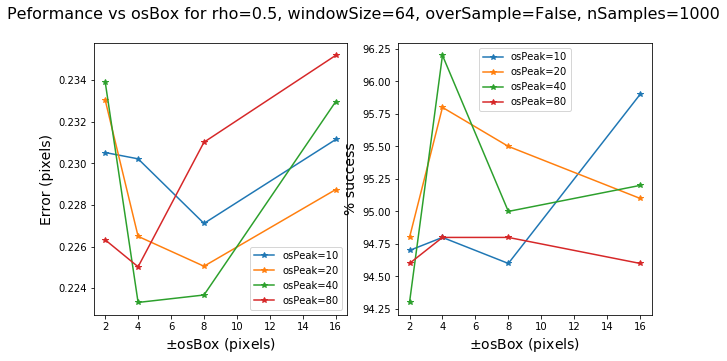

In [12]:
overSample = False
simOverSamplePeak(window, rho, overSample)

**Figure 3. Matching performance as a function of oversampled area around the peak ($\pm$`osBox`) with no overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to different over sampling factors (`osPeak`).**

The results all indicate generally poor peformance ($\sigma~=0.2$) irrespective of the sampling parameters, indicating the error from lack of oversampling dominates.

### Peak Oversampling for Matching with 2x Oversampling

This simulation is for case with 2x oversampling.

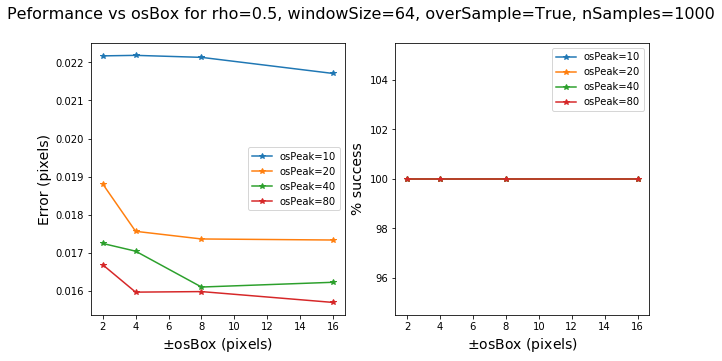

In [13]:
overSample = True
simOverSamplePeak(window, rho, overSample)

**Figure 4. Matching performance as a function of oversampled area around the peak ($\pm$'osBox') with 2x overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to different over sampling factors (`osPeak`).**

The results above are consistent with first two experiments focused on window size. Notably, the sub-pixel accuracy is greatly improved when the amplitude data are oversampled prior to matching. There is a performance penalty for the oversampling of about a factor of 8, but this cost is well worth the computational expense given the much better noise performance. The sweet spot seems to be something like `osBox=4` and `osPeak=40`. Interestingly, the accuracy is significantly better (~2x) than is the case for the corresponding complex examples (see complex notebook). This appears consistent with results for S1 data, though some of these differences even out when multiple samples are averaged (see complex tracking document). 

## Peak Oversampling with Gaussian Fit

Rather than oversampling the peak to the high resolution, offsets can be determined by fitting a Gaussian peak to less finely oversampled data (e.g., as in autoRift). The two examples repeat the two peak oversampling experiments described above but substitution of `nf.osSubPixGaussian` for `ns.osSubPix`. 

### Gausian Fit with no Initial Oversampling

In this example, there is no prior oversampling and a reduced the upper values of `osPeaks` and `osBoxes` are removed since the Gaussian fit makes up for the loss of resolution (Gaussian with that large a number of points also are very time consuming).

osBox=4 osPeak 4 .....x..

/home/ian/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


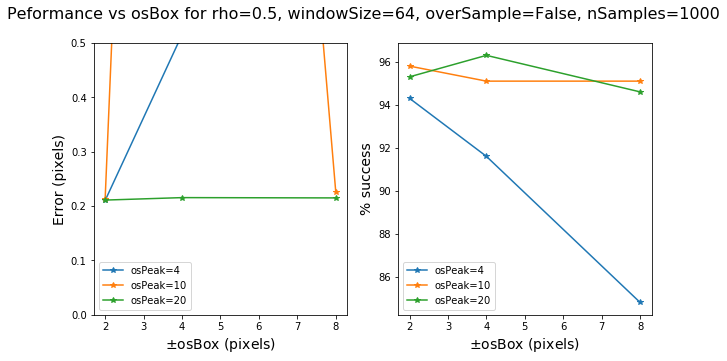

In [14]:
overSample = False
simOverSamplePeak(window, rho, overSample, osPeaks=[4, 10, 20], osBoxes=[2, 4, 8], subPix=nf.osSubPixGaussian, maxError=0.5)

**Figure 5. Matching performance for Gaussian fits as a function of oversampled area around the peak ($\pm$`osBox`) with no overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to different over sampling factors (`osPeak`). Note only a coarse first cut at discarding outliers used, which skews errors large for lower oversampling cases.**

### Gausian Fit with 2x Oversampling

This last example applies matching with 2x oversamping and oversamples the peak with the Gaussian fit. 

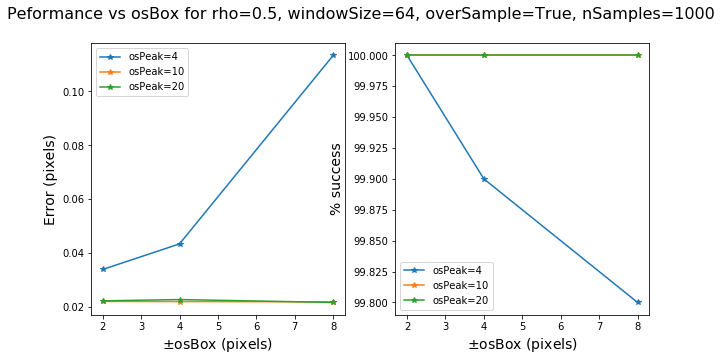

In [15]:
overSample = True
simOverSamplePeak(window, rho, overSample, osPeaks=[4, 10, 20], osBoxes=[2, 4, 8], subPix=nf.osSubPixGaussian)

**Figure 6. Matching performance for Gaussian fits as a function of oversampled area around the peak ($\pm$'osBox') with 2x overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to different over sampling factors (`osPeak`). Since the Gaussian fit is only to the main peak, wider boxes  yield poorer performance.**

## Conclusions

The plots shown above reveal several import performance characteristics of speckle-tracking methods applied to amplitude data. Specifically:
* For low correlation values (e.g., $\rho<=0.3$) large amplitude windows are needed (~64 or or greater) than is the case for complex matching.  In general, complex correlation can provide equal or better performance with smaller windows.
* Oversampling greatly improves results (errors can >20 times larger with no oversampling) and its hard to get sub-pixel errors <0.2 without oversampling. 
* For moderate to high coherence ($\rho > 0.4$), complex and amplitude matchng can deliver similar peformance. Various tradeoffs between resolution, averaging, fringe rates, and computational expense will determine whether amplitude or complex matching is best for a given level of correlation, $\rho$.

* The limit on how finely the correlation peak can be oversampled seems to be finer than for complex cross correlation. For high correlation ($\rho \ge 0.5$) errors can be reduced to about ~.07 pixels, which translates into a quantization step of $\Delta=0.024$, or roughly one fortieth of a pixel. 
* Direct oversampling (at least with $\rho=0.5$) seems to provide slightly better results, but with unknown differences in computational costs. The differences are small enough (0.005 pixels) that the fastest algorithm may be the best algorithm.